# Continuing Graphs of Specimens Over Time - Continents and GBIF

This notebook continues the work done in 01_iDigBio_Specimens_Collected_Over_Time.ipynb, you may want to review that notebook before contiuing. If you are interested in seeing what kinds of outputs are possible, you are welcome to skip to the graphs at the end of this notebook.

Our goal for this notebook is to see how many specimens were collected on each continent during each year from 1817 to 2017. A stacked bar graph with a different color for each continent is a good way to view this data.

We will introduce some additional concepts such as user defined functions, crosstabs, and how to write SQL statements instead of using the native pyspark methods. We'll move quickly though concepts already covered in earlier notebooks.

## Setup

Import needed functions and libraries.

In [1]:
# col() selects columns from a data frame, year() works on dates, and udf() creates user
# defined functions
from pyspark.sql.functions import col, year, udf

# Plotting library and configuration to show graphs in the notebook
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the data set

In [2]:
df = sqlContext.read.load("/guoda/data/idigbio-20190612T171757.parquet")

In [3]:
df.count()

105429263

## Year collected by continent

To get a feel for what a summary of year and continent look like, we will again group by the year column but also add the continent column. The result will be a row for each unique combination of year and continent with the count of how many times that occurs.

In [4]:
yc_sum = (df
          .groupBy(year("datecollected").cast("integer").alias("yearcollected"),
                   "continent")
          .count()
          .orderBy("yearcollected")
          )

In [5]:
yc_sum.head(20)

[Row(yearcollected=None, continent='australia', count=1390303),
 Row(yearcollected=None, continent='east indies', count=268),
 Row(yearcollected=None, continent='eurasie', count=33),
 Row(yearcollected=None, continent='afrotropique', count=252),
 Row(yearcollected=None, continent='middle of america, westcoast', count=1),
 Row(yearcollected=None, continent='europe, europe', count=1636),
 Row(yearcollected=None, continent='océanien', count=16203),
 Row(yearcollected=None, continent='sw pacific', count=3),
 Row(yearcollected=None, continent='arctic ocean', count=19825),
 Row(yearcollected=None, continent='northern america', count=2408),
 Row(yearcollected=None, continent='néotropique', count=384),
 Row(yearcollected=None, continent='sem informação', count=2),
 Row(yearcollected=None, continent='asia, europe', count=3),
 Row(yearcollected=None, continent='asia temperate', count=3),
 Row(yearcollected=None, continent='australia?', count=1),
 Row(yearcollected=None, continent='south american

There are a lot of things that are not continents there! While iDigBio cleans stuff up a bit before indexing it, not everything is obvious to do. For the purposes of our graph, we will make an "other" continent and group things that are not one of the 7 continents (plus "oceania" which GBIF uses and we'll look at GBIF data lower down) into that category.


## Fixing continent with a user defined function

To create a new column that has a fixed continent field, we will write a user defined function in Python and apply that function to every row in the data frame. This is exactly how the year() function from the pyspark library works. But, since we are writing the function in Python, we need to convert it into a data frame aware function with the pyspark function udf(). Once we do that, we can use our custom function just the same way we used year() above.

So let's write our Python function:

In [6]:
# allowed continents
continents = set(["africa", "australia", "asia", "oceania", "europe", "north america", "south america"])

def fix_continent(c):
    """
    If the given string contains one of the continents, return which one. If not
    then return "other". Lower case the string and also replace "_" with " " to
    be able to clean up GBIF's representation of continents that contain spaces.
    """
    for continent in continents:
        if (c) and (continent in c.lower().replace("_", " ")):
            return continent
    return "other"

# Some example calls to this function
print(fix_continent(None)) 
print(fix_continent("europe"))    
print(fix_continent("oceania"))
print(fix_continent("NORTH_AMERICA"))
print(fix_continent("North America, Canada, Manitoba, Churchill"))
print(fix_continent("East Indies, Indonesia: Pulo Pandjang, off Sumatra"))
print(fix_continent("Asia; Thailand; Pathum Thani"))

other
europe
oceania
north america
north america
other
asia


That output looks right. So now let's make a user defined function for Spark from our Python function. Notice that we pass the Python function as an argument to udf() and udf() returns to us a new function. In Python, functions are what's called "first class objects" and we can pass them around and manipulate them just like a variable.

In [7]:
fix_continent_udf = udf(fix_continent)

Now re-run our grouping. This time use the fix_continent_udf() function to calculate a new column and add it to the dataframe with the withColumn() method. Then we can refer to that new column in the group by method. (Yes, we could have put the fix_continent_udf() call into the group by just like we put the year() call but this is an opportunity to introduce withColumn().)

In [8]:
yc_sum = (df
          .withColumn("fixed", fix_continent_udf(df.continent))
          .groupBy(year("datecollected").cast("integer").alias("yearcollected"),
                   "fixed")
          .count()
          .orderBy("yearcollected")
          )

In [9]:
yc_sum.head(20)

[Row(yearcollected=None, fixed='africa', count=807947),
 Row(yearcollected=None, fixed='australia', count=1391203),
 Row(yearcollected=None, fixed='other', count=12824527),
 Row(yearcollected=None, fixed='south america', count=1414561),
 Row(yearcollected=None, fixed='europe', count=2324110),
 Row(yearcollected=None, fixed='north america', count=6798184),
 Row(yearcollected=None, fixed='oceania', count=446901),
 Row(yearcollected=None, fixed='asia', count=1480784),
 Row(yearcollected=100, fixed='north america', count=1),
 Row(yearcollected=100, fixed='other', count=1),
 Row(yearcollected=100, fixed='south america', count=1),
 Row(yearcollected=102, fixed='north america', count=1),
 Row(yearcollected=103, fixed='asia', count=1),
 Row(yearcollected=103, fixed='north america', count=1),
 Row(yearcollected=104, fixed='other', count=2),
 Row(yearcollected=105, fixed='other', count=5),
 Row(yearcollected=106, fixed='africa', count=3),
 Row(yearcollected=106, fixed='other', count=6),
 Row(yea

That looks much better. Notice now that we can actually see all of the yearcollected=None values. Before there were many continents so they went well past the top 20 results we were looking at. Now we can see all 8 counts, one for each continent.

## Cross tabs to make plottable data

What we have created at this point is a long list of year, continent, and count combinations. This representation of the data is normalized and can be thought of as the "long" form. Plotting wants to see each variable in one column though so the better represenation would the de-normalized or "wide" form. We can do this in Pandas with piviot() or in R you can use one of the reformating functions. We can also do this in Spark directly.

We will also take this opportunity to show how more typically a full data pipeline is shown in Spark. We will calculate the Pandas data frame all at once starting from the original df we loaded, filtering on years, creating the new fixed continents, and summarizing with group by. Each line in the pipeline below becomes the input for the next lower line. 

Notice that we first select only the columns of interest to let Spark know we don't need the other 200+ fields in iDigBio. Then we filter on year to cut down on the rows we need to work with. Only then do we run our udf which only runs on the filtered rows.

The new step in here is the crosstab() method. This is the method that takes all values in the column that is the second argument and makes them in to columns. You'll see the output after.

In [10]:
pandas_yc_cross = (df
            .select(year("datecollected").cast("integer").alias("yearcollected"),
                    df.continent)
            .filter(col("yearcollected") >= 1817)
            .filter(col("yearcollected") <= 2017)
            .withColumn("fixed", fix_continent_udf(df.continent))
            .crosstab("yearcollected", "fixed")
            .orderBy(col("yearcollected_fixed"))
            .toPandas()
            )

In [11]:
pandas_yc_cross.head(5)

,yearcollected_fixed,africa,asia,australia,europe,north america,oceania,other,south america
0,1817,77,139,391,534,471,100,290,1454
1,1818,43,250,480,805,5365,16,4246,361
2,1819,76,333,488,1065,560,42,873,313
3,1820,51,156,218,1745,644,8,1001,211
4,1821,79,715,115,1870,466,35,848,653


That looks pretty intuitive and we made the whole thing with one Spark statement. You can tell it's a Pandas dataframe now because the display is nice and tabular.

## Making the graph

Plotting isn't the focus of this notebook. Briefly, we'll make a function that stacks up multiple variables (continent counts) on top of each other and shades them different colors.

In [12]:
import pandas as pd
import numpy as np

def stack_bar_plot(pdf, columns, colors):
    """
    Matplotlib needs to have the bars stacked on top of each other by hand.
    First, we plot one column of data, then we make a ...
    """
    plots = []
    bottoms = pd.DataFrame(np.zeros((len(pdf['yearcollected_fixed']), 1)))
    for c in columns:
        plots.append(
          plt.bar(pdf['yearcollected_fixed'], pdf[c], 
                  color=colors[len(plots)], edgecolor='none',
                  width=1.0, bottom=bottoms[0])
        )
        bottoms[0] += pdf[c]
    return plots

and then we'll call our function to make the graph and add some axes.

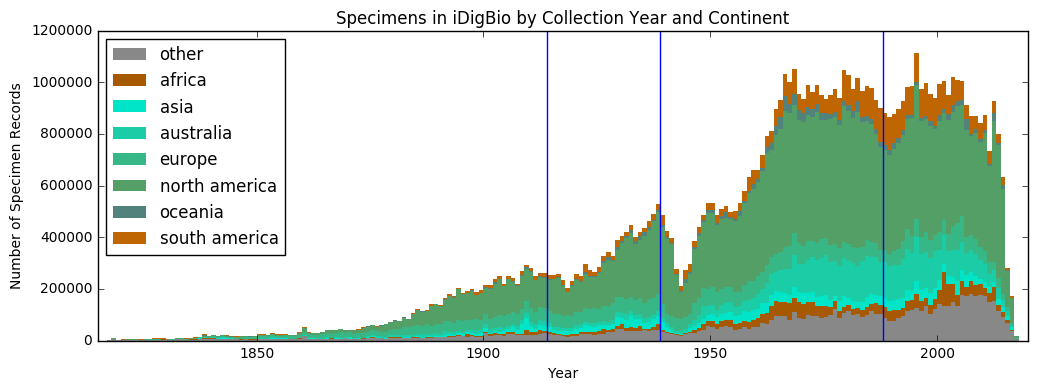

In [13]:
# set up ordering of continents and their colors
continents_list = sorted(continents)
continents_list.insert(0, "other")
colors = ["#888888", "#a75902", "#00e5c8", "#1bcda7", "#37b686", "#539f65", "#51827c", "#bf6603"]

plots = stack_bar_plot(pandas_yc_cross, continents_list, colors)
        
# Start of WWI
plt.axvline(x=1914)
# Start of WWII
plt.axvline(x=1939)
# "1988 - October 31: President Reagan signs the NSF Authorization Act of 1988,
# thereby authorizing the doubling of the NSF budget over the next five years."
plt.axvline(x=1988)

plt.legend(plots, continents_list, loc=2)
plt.title("Specimens in iDigBio by Collection Year and Continent")
plt.ylabel("Number of Specimen Records")
plt.xlabel("Year")
axes = plt.gca()
axes.set_xlim([1815, 2020])
axes.set_ylim([0, 1200000])
fig = plt.gcf()
fig.set_size_inches(12, 4)

There it is, the number of specimen records in iDigBio by collection date and continent. We chose to add some vertical lines to the graph at particularly interesting dates. You can read the code comments to see what those are.

## Doing the same with GBIF data

GBIF periocdically produces a similar graph to the above on their [analytics page](http://www.gbif.org/analytics/global) titled "Records by year of occurrence" but it's not very comparable because it include observation records as well. It would be great if we could run the same process on their data after filtering it for only specimens so we can look at how the contents of different occurrance record aggregators differs. (This is an expected and healthy thing. One of the goals of the GUODA collaboration is to begin to characterize the relationships between sets of aggregated data across domains without that work being done by one entity. Notice too that this copy of GBIF is pretty old. Again this is GUODA's fault as we have not been running our import regularly while we worked on improving other parts of our system.)

We can start by reading in the GBIF data that is stored in GUODA.

In [14]:
gbif_df = sqlContext.read.parquet("/guoda/data/gbif-idigbio.parquet/source=gbif/date=20160825")

We use a different process for formating GBIF data and as part of GUODA's process, the columns are named with a syntax that can be difficult to work with in Python. First let's use the SQL "as" syntax to rename the columns.

Spark data frames can also be manupulated with SQL statements instead of the pyspark functions. Note that Spark does not support the full SQL standard, it only supports syntx similar to the native functions.

The first step is to tell Spark what name we want to use to refer to our data frame with in the SQL. That is the createOrReplaceTempView() method. After than we can send our SQL as a string to the SQL Context associated with our Spark Context and we will get back a data frame. Because we'll use this data frame more than once, we'll persist it so it will not be recalculated.

As part of our SQL statement we will also filter for only those records that contain the string "SPECIMEN" in the basisOfRecord field. This may or may not be the best way to select only specimens from GBIF but for our graph it's good enough.

In [15]:
gbif_df.createOrReplaceTempView("gbif_df")

renamed_df = sqlContext.sql("""
SELECT `http://rs.tdwg.org/dwc/terms/eventDate` as eventDate,
       `http://rs.tdwg.org/dwc/terms/continent` as continent
FROM gbif_df
WHERE `http://rs.tdwg.org/dwc/terms/basisOfRecord` LIKE "%SPECIMEN%"
""").persist()

In [16]:
renamed_df.count()

63184115

We will again run the crosstab all at once on this data frame with renamed columns. This is exactly the same summarization we ran on the iDigBio data frame.

In [17]:
pandas_yc_cross_gbif = (renamed_df
            .select(year("eventDate").cast("integer").alias("yearcollected"),
                    renamed_df.continent)
            .filter(col("yearcollected") >= 1817)
            .filter(col("yearcollected") <= 2017)
            .withColumn("fixed", fix_continent_udf(renamed_df.continent))
            .crosstab("yearcollected", "fixed")
            .orderBy(col("yearcollected_fixed"))
            .toPandas()
            )


In [18]:
pandas_yc_cross_gbif.head(5)

,yearcollected_fixed,africa,asia,europe,north america,oceania,other,south america
0,1817,5,7,67,14,23,344,72
1,1818,5,108,69,7,43,423,112
2,1819,14,140,91,19,45,400,83
3,1820,4,31,265,225,38,505,79
4,1821,5,121,273,203,10,297,81


And we'll use the exact same code for graphing as well. We just need to remove the "australia" and it's color from our continent list because GBIF doesn't use it.

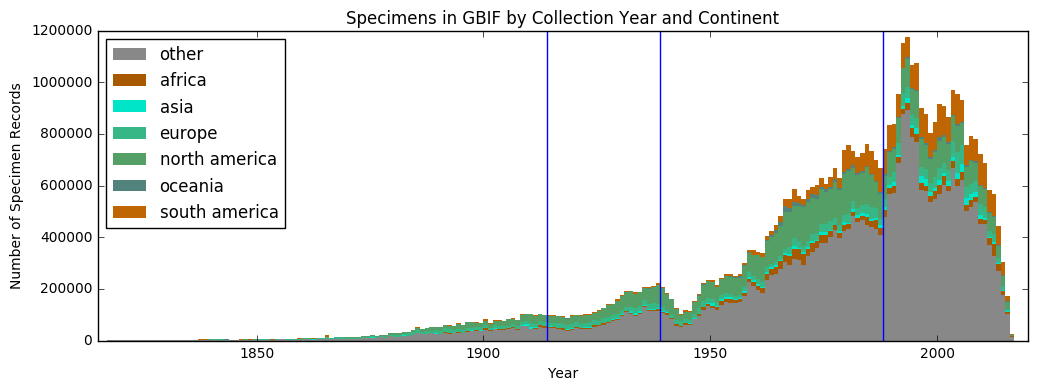

In [19]:
# GBIF doesn't have "australia"
try:
    continents_list.remove("australia")
    colors.remove("#1bcda7")
except:
    pass

plots = stack_bar_plot(pandas_yc_cross_gbif, continents_list, colors)

# Start of WWI
plt.axvline(x=1914)

# Start of WWII
plt.axvline(x=1939)

# "1988 - October 31: President Reagan signs the NSF Authorization Act of 1988, thereby authorizing the doubling of the NSF budget over the next five years."
plt.axvline(x=1988)

plt.legend(plots, continents_list, loc=2)
plt.title("Specimens in GBIF by Collection Year and Continent")
plt.ylabel("Number of Specimen Records")
plt.xlabel("Year")
axes = plt.gca()
axes.set_xlim([1815, 2020])
axes.set_ylim([0, 1200000])
fig = plt.gcf()
fig.set_size_inches(12, 4)